# Introduction

In this tutorial, we do sentiment analysis using the deep learning classifier from Keras. We use the airline sentiment data from earlier workshops. We introduce the use of Keras 

We'll do the following:
- Fit a deep learning model with Keras using dense feedforward network
- Identify and deal with overfitting
- Test the accuracy of a pretrained model

## Set-up of the project
We'll start by importing some packages. The Keras is a backend to the DL libraries - tensorflow, Theano or CNTK. Installation may be done using https://keras.io/#installation It recenty release the Keras 2.0, and we can use the latest version for this purpose.

In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [2]:
# Basic packages
# conda install nb_conda --> to install kernel with tensorflow virtualenv
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn import utils

# Packages for modeling
import keras
from keras import models
from keras import layers
from keras import regularizers
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
print (keras.__version__)

Using TensorFlow backend.


2.2.4


Then we set some parameters that will be used throughout the notebook. The batch size is the number of samples processed before the model is updated. The number of epochs is the number of complete passes (iteration) through the training dataset.

## Setting global variables

In [3]:
NB_WORDS = 35000  # Parameter indicating the number of words we'll put in the dictionary to create word vector
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 12  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
target_names = ['Bullish', 'Bearish']

## Reading in the data and doing some pre-processing. 

In [4]:
xls1 = pd.ExcelFile('data/stocktwits_sentiment_subjectivity_Feb-01-2020.lsx')
xls2 = pd.ExcelFile('data/twiters_label_data_Feb-02-2020.xlsx')
df_1 = pd.read_excel(xls1, 'stocks_label')
df_2 = pd.read_excel(xls2, 'stocks_label')
df_1 = df_1[['text', 'sentiment']]


Split the data to training and test set before upsampling

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_1.text, df_1.sentiment, test_size=0.1, random_state=37,shuffle=True,stratify = df_1.sentiment)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 41659
# Test data samples: 4629


In [6]:
len(X_train)

41659

In [7]:
stocks_1 = pd.concat([X_train,y_train],axis=1)

In [8]:
len(stocks_1)

41659

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_2.text, df_2.sentiment, test_size=0.1, random_state=37,shuffle=True,stratify = df_2.sentiment)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 1176
# Test data samples: 131


In [10]:
len(X_train)

1176

In [11]:
stocks_2 = pd.concat([X_train,y_train],axis=1)

In [12]:
len(stocks_2)

1176

In [13]:
df = pd.concat([stocks_1,stocks_2])

In [14]:
len(df)

42835

UpSampling the datasets

In [15]:
stocks_bullish = df[df.sentiment == 'Bullish'] 
stocks_bearish = df[df.sentiment == 'Bearish']

In [16]:
bearish_upsampled = utils.resample(stocks_bearish, 
                                 replace=True,                         # sample with replacement
                                 n_samples=stocks_bullish.shape[0],    # to match majority class
                                 random_state=42)

In [17]:
bearish_upsampled.shape

(32846, 2)

In [18]:
stocks = pd.concat([stocks_bullish,bearish_upsampled])

In [19]:
stocks['sentiment'].value_counts()

Bearish    32846
Bullish    32846
Name: sentiment, dtype: int64

In [20]:
stocks = stocks.sample(frac=1).reset_index(drop=True)
df     = stocks.reindex(np.random.permutation(stocks.index)) 

In [21]:
df.head()

,text,sentiment
40673,dow,Bearish
44579,let close 560,Bearish
2632,cheap value play growth,Bullish
55840,ole sayin,Bearish
50960,know already know earnings announcement tsla j...,Bullish


In [22]:
df.sentiment.value_counts()

Bearish    32846
Bullish    32846
Name: sentiment, dtype: int64

In [23]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        # whitelist = ["n't", "not", "no"]
        whitelist = []
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)

In [24]:
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)
df.head()

,text,sentiment
40673,dow,Bearish
44579,let close 560,Bearish
2632,cheap value play growth,Bullish
55840,ole sayin,Bearish
50960,know already know earnings announcement tsla j...,Bullish


Segment the data into test and train data sets. 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.sentiment, test_size=0.1, random_state=37,shuffle=True,stratify = df.sentiment)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 59122
# Test data samples: 6570


In [26]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

In [27]:
print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 59122 documents
35000 words in dictionary
Top 5 most common words are: [('market', 3697), ('like', 3494), ('going', 3422), ('today', 3415), ('get', 3082)]


In [28]:
# THis list numbers represent the column number that contains a 1 for the word vector
# the columns are the features. Is a better way to represent the word vector rather than using 30000 features where most are 0
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)
print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

"top sell money flow 2017" is converted into [4, 468]


One hot encoding is very explained [in this link.](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f#targetText=One%20hot%20encoding%20is%20a,the%20entry%20in%20the%20dataset)
Essentially, it is a binary indicator of whether a feature (word etc) exists in the training documents or not. It is used in this instance as instead of showing the positional index of a particular word, it indicates 1/0 if the word is present in the document.
    

In [29]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

In [30]:
X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

"[4, 468]" is converted into [0. 0. 0. ... 0. 0. 0.]
For this example we have 2.0 features with a value of 1.


In [31]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)
print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"Bearish" is converted into 0
"0" is converted into [1. 0.]


In [32]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37,shuffle=True,stratify = y_train_oh)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (5913, 35000)


### Set-up of Dense Feedforward Classifier
The model used is a sequential model with 2 intermediate hidden layers. In the input layer, there are 64 neurons (what is described as a perceptron). As there are 10000 words, total no of parameters in the first layer = 64*10000 + 64 (for constants) = 640064.

In the 2nd layer, this takes the output from the 1st layer (64 outputs from the 64 neurons) Total no of parameters = 64-64 + 64 = 4160.

There are 3 outputs (shape) from the last output layer which correspond to probabilities of the 3 classes - positive, negative and neutral. Total no of parameters = 64* 3 +3 = 195

The Dense FNN is the simplest model that should be understood first in DL.

In [33]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
base_model.add(Dropout(0.5))
base_model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
base_model.add(Dropout(0.5))
base_model.add(layers.Dense(2, activation='softmax'))
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                2240064   
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)      

Next, the model is compiled. The loss function is meant for categorical classifications. 
$-(y log(p) + (1-y) log(1-p))$ So suppose for a positive label, and the classifier classes the positive/ negative classes as (0.8,0.2), $p=0.8, y=1$ for the cross entropy calculated as $0.223$. If it classifies as 100% positive, the cross entropy is 0.

In [34]:
def deep_model(model):
    model.compile(optimizer='adam'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs= NB_START_EPOCHS
                       , batch_size= BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
    
    return history
base_history = deep_model(base_model)

Instructions for updating:
Use tf.cast instead.
Train on 53209 samples, validate on 5913 samples
Epoch 1/12
53209/53209 [==============================] - 67s 1ms/step - loss: 0.6241 - acc: 0.7131 - val_loss: 0.4626 - val_acc: 0.8114
Epoch 2/12
53209/53209 [==============================] - 55s 1ms/step - loss: 0.3549 - acc: 0.8723 - val_loss: 0.3504 - val_acc: 0.8694
Epoch 3/12
53209/53209 [==============================] - 47s 882us/step - loss: 0.2080 - acc: 0.9359 - val_loss: 0.3140 - val_acc: 0.8941
Epoch 4/12
53209/53209 [==============================] - 44s 824us/step - loss: 0.1255 - acc: 0.9695 - val_loss: 0.3332 - val_acc: 0.9085
Epoch 5/12
53209/53209 [==============================] - 36s 669us/step - loss: 0.0820 - acc: 0.9846 - val_loss: 0.3389 - val_acc: 0.9144
Epoch 6/12
53209/53209 [==============================] - 41s 777us/step - loss: 0.0648 - acc: 0.9900 - val_loss: 0.3488 - val_acc: 0.9187
Epoch 7/12
53209/53209 [==============================] - 39s 742us/step 

Note the below, where with the no of epochs (iterations), the train loss decreases. However, the validation losses increases. This is a symptom of over-fitting. Too often, this occurs for deep learning. The same thing occurs for the accuracy, which increases for the training set but remain stagnant for the validation set.

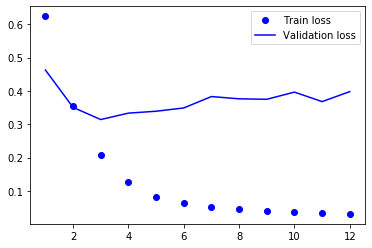

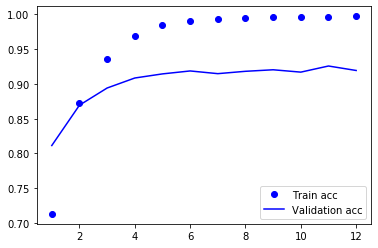

In [35]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()
    
eval_metric(base_history, 'loss')
eval_metric(base_history, 'acc')

In the next example, what we do is to remove one hidden layer and also decrease the no of neurons from 64 to 32. This will hopefully reduce over-fitting

### Less over-fitting with reduced model
Indeed as we observe, the baseline model sees increasing losses while the reduced model (with fewer neurons and one hidden layer less) loss does not increase even with increasing epochs.

In [36]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()
    

### Testing model results
We use out models for in-sample testing of the data. In fact the 3 models (regularised, drop-out and reduced models) all work well in spite of controlling for over-fitting as seen by a higher accuracy.

In [37]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=1)
    #predictions = model.predict(X_test_oh)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    #print('Confusion Matrix')
    #print(confusion_matrix(y_test_oh, predictions))
    #print('Classification Report')
    #print(classification_report(y_test_oh, predictions, target_names=target_names))
    return results,

base_results = test_model(base_model, 12)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[0][1]*100))

Epoch 1/12
59122/59122 [==============================] - 64s 1ms/step - loss: 0.0658 - acc: 0.9886
Epoch 2/12
59122/59122 [==============================] - 38s 643us/step - loss: 0.0371 - acc: 0.9949
Epoch 3/12
59122/59122 [==============================] - 42s 712us/step - loss: 0.0295 - acc: 0.9970
Epoch 4/12
59122/59122 [==============================] - 39s 667us/step - loss: 0.0262 - acc: 0.9976
Epoch 5/12
59122/59122 [==============================] - 40s 676us/step - loss: 0.0249 - acc: 0.9978
Epoch 6/12
59122/59122 [==============================] - 38s 648us/step - loss: 0.0237 - acc: 0.9979
Epoch 7/12
59122/59122 [==============================] - 42s 714us/step - loss: 0.0219 - acc: 0.9983
Epoch 8/12
59122/59122 [==============================] - 38s 642us/step - loss: 0.0213 - acc: 0.9982
Epoch 9/12
59122/59122 [==============================] - 39s 658us/step - loss: 0.0208 - acc: 0.9982
Epoch 10/12
59122/59122 [==============================] - 35s 597us/step - loss: 0.

 ### Increase depth with dropout, regulariser and Batch normalisation

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               17920512  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
__________

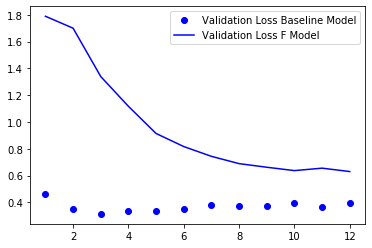

In [38]:
F_model = models.Sequential()
F_model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001),input_shape=(NB_WORDS,)))
F_model.add(layers.Dropout(0.5))
F_model.add(BatchNormalization())
F_model.add(layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
F_model.add(layers.Dropout(0.5))
F_model.add(BatchNormalization())
F_model.add(layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
F_model.add(layers.Dropout(0.4))
F_model.add(BatchNormalization())
F_model.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
F_model.add(layers.Dropout(0.4))
F_model.add(BatchNormalization())
F_model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
F_model.add(layers.Dropout(0.3))
F_model.add(BatchNormalization())
F_model.add(layers.Dense(2, activation='softmax'))
F_model.summary()

history = deep_model(F_model)

compare_loss_with_baseline(history, 'F Model')

In [39]:
results = test_model(F_model, 12)
print('Test accuracy of model: {0:.2f}%'.format(results[0][1]*100))

Epoch 1/12
59122/59122 [==============================] - 83s 1ms/step - loss: 0.5197 - acc: 0.9575
Epoch 2/12
59122/59122 [==============================] - 73s 1ms/step - loss: 0.5050 - acc: 0.9615
Epoch 3/12
59122/59122 [==============================] - 72s 1ms/step - loss: 0.4943 - acc: 0.9650
Epoch 4/12
59122/59122 [==============================] - 68s 1ms/step - loss: 0.5029 - acc: 0.9619
Epoch 5/12
59122/59122 [==============================] - 70s 1ms/step - loss: 0.4999 - acc: 0.9648
Epoch 6/12
59122/59122 [==============================] - 71s 1ms/step - loss: 0.4946 - acc: 0.9648
Epoch 7/12
59122/59122 [==============================] - 69s 1ms/step - loss: 0.4996 - acc: 0.9642
Epoch 8/12
59122/59122 [==============================] - 72s 1ms/step - loss: 0.5111 - acc: 0.9624
Epoch 9/12
59122/59122 [==============================] - 69s 1ms/step - loss: 0.5045 - acc: 0.9650
Epoch 10/12
59122/59122 [==============================] - 68s 1ms/step - loss: 0.5028 - acc: 0.9652

## Save model and retest

In [40]:
import pickle

filename = 'finalized_Keras_model.sav'
pickle.dump(F_model, open(filename, 'wb'))

In [41]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.evaluate(X_test_oh, y_test_oh)
print(result)

6570/6570 [==============================] - 8s 1ms/step
[0.6189068337553713, 0.934855403348554]


In [42]:
# serialize model to JSON
model_json = F_model.to_json()
with open("Keras_FNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
F_model.save_weights("Keras_FNN_model.h5")
print("Saved model to disk")

Saved model to disk


In [44]:
from keras.models import model_from_json

# load json and create model
json_file = open('Keras_FNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Keras_FNN_model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X_test_oh, y_test_oh, verbose=1)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
6570/6570 [==============================] - 8s 1ms/step
acc: 93.49%
